In [3]:
library(ggplot2)
library(dplyr)
library(ggdist)
library(lme4)
library(ggeffects)
library(patchwork)
library(lmerTest)
library(brms)
library(blme)
library(rlang)
library(glmmTMB)

library(broom.mixed)


In [40]:
# Load data
data <- read.csv("data/studyResultsPilot.csv", header=T)

data <- data %>%
  mutate(anchor = ifelse(anchorCategory == "anchor", "anchor", "non-anchor"))

data <- data %>%
  mutate(alignment = ifelse(alignmentCategory == "aligned", "aligned", "unaligned"))

data <- data %>%
  mutate(anchorType = case_when(
    selectedPart == 25 ~ "25",
    selectedPart == 50 ~ "50",
    TRUE ~ "non-anchor"
))

data$alignment <- factor(data$alignment, levels = c("aligned", "unaligned"))
data$anchor <- factor(data$anchor, levels = c("anchor", "non-anchor"))
data$chartType <- factor(data$chartType, levels = c("pie", "line"))

data$alignmentCategory <- factor(data$alignmentCategory, levels = c("aligned", "near-aligned", "far-from-aligned"))
data$anchorCategory <- factor(data$anchorCategory, levels = c("anchor", "near-anchor", "far-anchor"))

data$distToNearest5 <- abs(data$selectedPart - round(data$selectedPart / 5) * 5)
data$distToNearest10 <- abs(data$selectedPart - round(data$selectedPart / 10) * 10)

head(data)

,responseTime,prolificID,userID,questionNum,response,loadTime,questionID,selectedPart,alignmentCategory,anchorCategory,⋯,F_ind,G_ind,error,absError,correct,anchor,alignment,anchorType,distToNearest5,distToNearest10
,<dbl>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<fct>,<fct>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,11.048,67bdb56696615a171c91c62c,1,1,55,2025-04-21 19:28:36.484,1,40,aligned,far-anchor,⋯,3,0,15,15,False,non-anchor,aligned,non-anchor,0,0
2,7.346,67bdb56696615a171c91c62c,1,2,15,2025-04-21 19:28:47.809,2,46,far-from-aligned,near-anchor,⋯,1,3,-31,31,False,non-anchor,unaligned,non-anchor,1,4
3,6.502,67bdb56696615a171c91c62c,1,3,80,2025-04-21 19:28:55.420,3,21,near-aligned,near-anchor,⋯,0,2,59,59,False,non-anchor,unaligned,non-anchor,1,1
4,5.066,67bdb56696615a171c91c62c,1,4,22,2025-04-21 19:29:02.263,4,19,near-aligned,far-anchor,⋯,4,6,3,3,False,non-anchor,unaligned,non-anchor,1,1
5,4.608,67bdb56696615a171c91c62c,1,5,18,2025-04-21 19:29:07.603,5,35,far-from-aligned,far-anchor,⋯,1,6,-17,17,False,non-anchor,unaligned,non-anchor,0,5
6,11.841,67bdb56696615a171c91c62c,1,6,22,2025-04-21 19:29:12.481,6,18,far-from-aligned,far-anchor,⋯,4,5,4,4,False,non-anchor,unaligned,non-anchor,2,2


In [42]:
model <- glmmTMB(
  absError ~ (chartType * anchor * alignment) + (1 + anchor + alignment + chartType || userID),
  data = data,
  family = tweedie(link = "log")
)

summary(model)

 Family: tweedie  ( log )
Formula:          
absError ~ (chartType * anchor * alignment) + (1 + anchor + alignment +  
    chartType || userID)
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
   5379.9    5448.1   -2676.0    5351.9       948 

Random effects:

Conditional model:
 Groups Name               Variance Std.Dev. Corr           
 userID (Intercept)        1.91513  1.3839                  
        anchornon-anchor   0.49416  0.7030   0.00           
        alignmentunaligned 0.02846  0.1687   0.00 0.00      
        chartTypeline      0.03511  0.1874   0.00 0.00 0.00 
Number of obs: 962, groups:  userID, 10

Dispersion parameter for tweedie family (): 2.14 

Conditional model:
                                                  Estimate Std. Error z value
(Intercept)                                         0.7637     0.5082   1.503
chartTypeline                                       0.6158     0.3018   2.041
anchornon-anchor                                    0.7

In [49]:
simulate_pvals <- function(data, n_participants) {
  users <- unique(data$userID)
  sampled_users <- sample(users, size = n_participants, replace = TRUE)

  boot_data <- do.call(rbind, lapply(seq_along(sampled_users), function(i) {
    d <- data %>% filter(userID == sampled_users[i])
    d$userID <- paste0("boot_", i)
    return(d)
  }))

  model <- tryCatch({
    glmmTMB(
      absError ~ chartType * (anchor + alignment) + distToNearest5 +
        (1 + anchor + alignment + distToNearest5 || userID),
      data = boot_data,
      family = tweedie(link = "log")
    )
  }, error = function(e) return(NULL))

  if (is.null(model)) return(rep(NA, 5))

  tidy_mod <- broom.mixed::tidy(model)
  pvals <- tidy_mod$p.value
  names(pvals) <- tidy_mod$term

  return(c(
    chartType = pvals["chartTypepie"],
    anchor = pvals["anchornon-anchor"],
    alignment = pvals["alignmentunaligned"],
    chartType_anchor = pvals["chartTypepie:anchornon-anchor"],
    chartType_alignment = pvals["chartTypepie:alignmentunaligned"]
  ))
}

In [50]:
participants <- c(10, 20, 30, 40, 50, 60, 70, 80)
simulationCount <- 2

set.seed(123)

pval_results <- lapply(participants, function(n) {
  sim_matrix <- replicate(simulationCount, simulate_pvals(data, n))
  
  # Convert to data frame
  df <- as.data.frame(t(sim_matrix))  # rows = simulations, columns = effects

  # Compute mean and CI manually for each effect
  stats_list <- lapply(names(df), function(effect) {
    pvals <- df[[effect]]
    data.frame(
      N = n,
      Effect = effect,
      MeanP = mean(pvals, na.rm = TRUE),
      Lower = quantile(pvals, 0.025, na.rm = TRUE),
      Upper = quantile(pvals, 0.975, na.rm = TRUE)
    )
  })

  do.call(rbind, stats_list)
})

# Combine all sample sizes
pval_ci_df <- do.call(rbind, pval_results)

Warning message:
“Removed 24 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


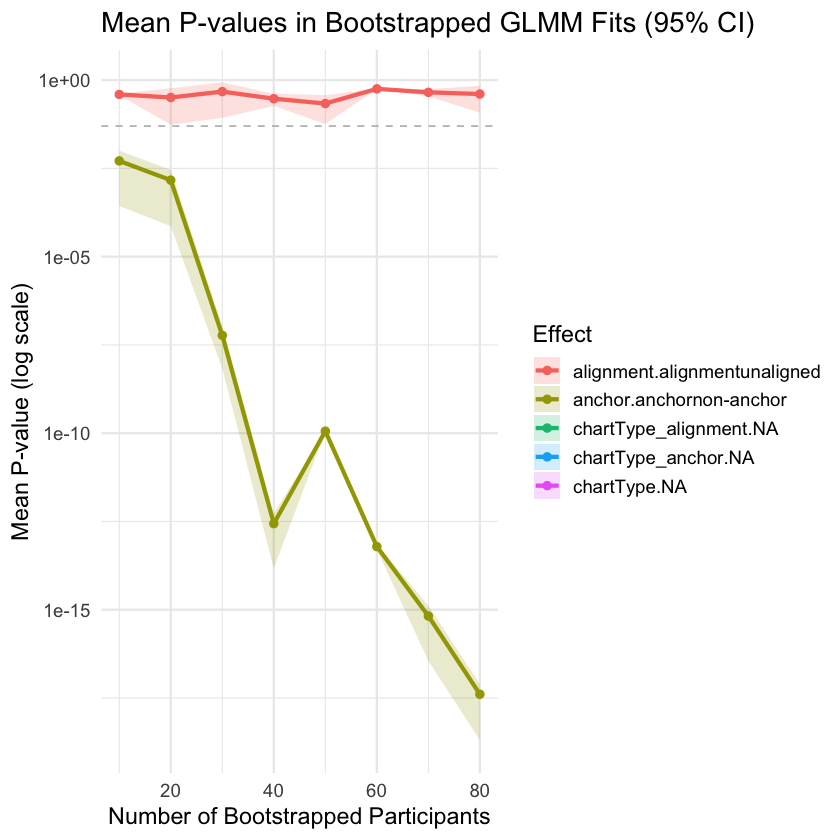

In [51]:
ggplot(pval_ci_df, aes(x = N, y = MeanP, color = Effect, fill = Effect)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.2, color = NA) +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "gray") +
  scale_y_continuous(trans = "log10") +
  theme_minimal(base_size = 14) +
  labs(
    title = "Mean P-values in Bootstrapped GLMM Fits (95% CI)",
    x = "Number of Bootstrapped Participants",
    y = "Mean P-value (log scale)",
    color = "Effect",
    fill = "Effect"
  )